# From Zero to Alph-Zero 

Inspired by:  
*Mastering Chess and Shogi by Self-Play with a
General Reinforcement Learning Algorithm* (https://arxiv.org/pdf/1712.01815)

**Our Methodology**

We decompose our method in 2 steps.


- **Firstly**: train a value function capable of evaluating a chess board. 
Initialize a stockfish chess engine with high performance. 
Simulate 20 000 of games by making a stockfish engine play against stockfish engine. 
Evaluate each position with the high performance stockfish chess engine.
Train a CNN-Neural network by supervision on the games. Play with it, combining it with alpha/beta search.   
- **Secondly**: train a policy by reinforcement using alpha-zero methodology. Alpha-zero is only based on data from self-play and exceeds the best traditional AIs perfomance significatively. Isn’t restricted to a game and uses Monte Carlo Tree Search instead of alpha/beta search. The Monte Carlo Tree Search is decomposed in 4 steps: 
    1. Selection: The algorithm chooses which child node to explore depending on the number of visit and the value of the node. 
    2. Expansion:  When a has unvisited children, the tree is expanded by adding one child. The Neural Network chooses which one using its policy. 
    3. Simulation: The outcome of the game is predicted by the value function. 
    4. Backpropagation: The result of the simulation is propagated back up the tree, the value of the node and the number of visit are updated.   

In our method, rather than training the value function by reinforcement (costly), we: 
- Initialize a high performance stockfish chess engine
- Replace the prediction (simulation step) by a stockfish evaluation that will be propagated as a score. 
- Simulate self-played games and add some randomness (Dirichlet noise, temperature). 
- Train a Resnet-type Neural network by reinforcement with a policy head only.

## Imports

In [41]:
import concurrent.futures
import glob
import json
import os
import random

import concurrent.futures
import glob
import json
import os
import random
from contextlib import redirect_stdout

import chess
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from IPython.display import SVG, display
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from stockfish import Stockfish
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    Activation, Add, BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, Softmax
)
from tensorflow.keras.models import Model
from tqdm import tqdm
import tensorflow as tf


import chess
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from IPython.display import SVG, display
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from stockfish import Stockfish
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    Activation, Add, BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, Softmax
)
from tensorflow.keras.models import Model
from tqdm import tqdm
import tensorflow as tf


## Utils 

Create a function that transforms the chess bord into a (8, 8, 14) tensor. 8x8 as the chess board size, the first 12 dimensions to localise each piece and dimensions 13 and 14 for encoding the turn and the number of move played. 

In [42]:
def board_to_tensor(board):
    """
    Args:
        board (chess.Board): The chess board to convert.

    Returns:
        np.ndarray: A tensor of shape (8, 8, 14), ready to be used by a CNN.
    """
    # Initialize a tensor of dimensions (8, 8, 14) filled with zeros
    tensor = np.zeros((8, 8, 14))

    if type(board) == str:  
        board = chess.Board(fen=board)
    # Get a map of pieces on the board (position -> piece)
    piece_map = board.piece_map()

    # Iterate over all positions containing pieces
    for square, piece in piece_map.items():
        # Determine the plane corresponding to the piece type (0 to 5 for White)
        plane = piece.piece_type - 1  # Piece types start at 1 (Pawn)

        # Adjust for Black pieces (6 to 11)
        if piece.color == chess.BLACK:
            plane += 6

        # Convert the position to coordinates (x, y) for the 8x8 array
        x, y = divmod(square, 8)

        # Place a 1 in the corresponding plane for this piece
        tensor[x, y, plane] = 1

    # Plane 12: Indicates the player to move (1 for White, 0 for Black)
    tensor[:, :, 12] = 1 if board.turn == chess.WHITE else 0

    # Plane 13: Contains the full move number
    tensor[:, :, 13] = board.fullmove_number

    return tensor

board = chess.Board()


Example of tensor representing the chess board for the initial board

In [43]:
board_to_tensor(board)

array([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        

Function used to evaluate the board, given an evaluation model.


In [44]:
def evaluate_board(model, position):
    input_vector = board_to_tensor(position)
    return float(model.predict(np.expand_dims(input_vector, axis=0), verbose=0)[0][0])

def evaluate_position_stockfish(stockfish_evaluator, fen):
    stockfish_evaluator.set_fen_position(fen)
    return stockfish_evaluator.get_evaluation()["value"]

Following the Alpha-zero methodology we implement the following functions. 
The tensors are the predictions made by the neural network, or Policy. Based on a policy and a chess board, we can get move probabilities. Move probabilities can also be converted to tensor in the other way. 

In [45]:
def tensor_to_move_probabilities(tensor, board):
    """
    Transforms a tensor of shape (batch x 8x8x73) into a dictionary mapping moves to probabilities.

    Args:
        tensor (np.array): Tensor of shape (batch x 8x8x73) with unnormalized move probabilities.
        board (chess.Board): A python-chess Board representing the current position.

    Returns:
        dict: A dictionary where keys are legal moves (in UCI format, e.g., "e2e4")
              and values are their normalized probabilities.
    """
    # List legal moves
    legal_moves = list(board.legal_moves)

    # If the tensor has a batch dimension, select the first element
    if len(tensor.shape) == 4:
        tensor = tensor[0]

    # Initialize the dictionary to hold move probabilities
    move_probabilities = {}

    for move in legal_moves:
        from_square = move.from_square
        to_square = move.to_square

        from_x, from_y = chess.square_file(from_square), chess.square_rank(from_square)
        to_x, to_y = chess.square_file(to_square), chess.square_rank(to_square)

        dx = to_x - from_x
        dy = to_y - from_y

        # Identify the plane corresponding to the move
        if abs(dx) == abs(dy) or dx == 0 or dy == 0:  # Linear moves
            direction = {
                (1, 0): 0, (0, 1): 1, (-1, 0): 2, (0, -1): 3,
                (1, 1): 4, (-1, 1): 5, (-1, -1): 6, (1, -1): 7
            }[(np.sign(dx), np.sign(dy))]
            plane_index = direction * 7 + max(abs(dx), abs(dy)) - 1
        elif abs(dx) in [1, 2] and abs(dy) in [1, 2]:  # Knight moves
            plane_index = 56 + ((2 + dx) * 3 + (2 + dy))
        elif board.piece_type_at(from_square) == chess.PAWN and board.is_promotion(move):  # Promotions
            promotion = move.promotion
            plane_index = 64 + {chess.KNIGHT: 0, chess.BISHOP: 1, chess.ROOK: 2}[promotion]
        else:
            continue

        # Extract the probability from the tensor for the move
        prob = tensor[from_y, from_x, plane_index]
        move_probabilities[move.uci()] = prob

    # Normalize probabilities
    total_prob = sum(move_probabilities.values())
    if total_prob > 0:
        move_probabilities = {move: prob / total_prob for move, prob in move_probabilities.items()}

    return move_probabilities

def move_probabilities_to_tensor(move_probabilities, board):
    """
    Transforms a dictionary of moves and probabilities into an 8x8x73 tensor.

    Args:
        move_probabilities (dict): A dictionary where keys are moves (UCI format)
                                   and values are their probabilities.
        board (chess.Board): A python-chess Board representing the current position.

    Returns:
        np.array: An 8x8x73 tensor containing the move probabilities.
    """
    # Initialize an 8x8x73 tensor with zeros
    tensor = np.zeros((8, 8, 73), dtype=np.float32)

    for move_uci, prob in move_probabilities.items():
        # Convert the move from UCI format to a Move object
        move = chess.Move.from_uci(move_uci)
        from_square = move.from_square
        to_square = move.to_square

        from_x, from_y = chess.square_file(from_square), chess.square_rank(from_square)
        to_x, to_y = chess.square_file(to_square), chess.square_rank(to_square)

        dx = to_x - from_x
        dy = to_y - from_y

        # Identify the plane corresponding to the move
        if abs(dx) == abs(dy) or dx == 0 or dy == 0:  # Linear moves
            direction = {
                (1, 0): 0, (0, 1): 1, (-1, 0): 2, (0, -1): 3,
                (1, 1): 4, (-1, 1): 5, (-1, -1): 6, (1, -1): 7
            }[(np.sign(dx), np.sign(dy))]
            plane_index = direction * 7 + max(abs(dx), abs(dy)) - 1
        elif abs(dx) in [1, 2] and abs(dy) in [1, 2]:  # Knight moves
            plane_index = 56 + ((2 + dx) * 3 + (2 + dy))
        elif board.piece_type_at(from_square) == chess.PAWN and board.is_promotion(move):  # Promotions
            promotion = move.promotion
            plane_index = 64 + {chess.KNIGHT: 0, chess.BISHOP: 1, chess.ROOK: 2, chess.QUEEN: 3}[promotion]
        else:
            continue

        # Update the tensor with the corresponding probability
        tensor[from_y, from_x, plane_index] = prob

    return tensor


# Supervised approach for chess: train a value function 

## Generate a dataset of games with each position evaluated 

Here we make stockfish play against iteself thousands of times (around 10,000) by introducing a bit of randomness to create various position and make it evaluate by the best stockfish evaluator we can do. As a result we've got a high quality data of this form:  
- {"move": "e2e4", "evaluation": -36, "position": "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"}  
With the position encoded in fen (typical encoding of a chess board)


In [46]:
load_dotenv(dotenv_path="src/config/.env")  # Load environment variables from the .env file
path_stockfish = os.getenv("PATH_STOCKFISH")

def configure_stockfish(path, elo, depth, threads, min_time):
    return Stockfish(
        path=path,
        parameters={
            "Threads": threads,
            "Minimum Thinking Time": min_time
        }
    ), elo, depth

def checkEndCondition(board):
    return (board.is_checkmate() or board.is_stalemate() or 
            board.is_insufficient_material() or board.can_claim_threefold_repetition() or 
            board.can_claim_fifty_moves() or board.can_claim_draw())

def findNextIdx():
    files = glob.glob(r"data/*.json")
    if len(files) == 0:
        return 1  # if no files, return 1
    highestIdx = max(int(f.split("MovesAndPositions")[-1].split(".json")[0]) for f in files)
    return highestIdx + 1

def saveData(moves, positions, evaluations):
    MovesAndPositions = [{"move": move, "evaluation": evaluation, "position": position} 
                         for move, evaluation ,position in zip(moves, evaluations, positions)]
    nextIdx = findNextIdx()
    with open(f"data/MovesAndPositions{nextIdx}.json", "w") as json_file:
        json.dump(MovesAndPositions, json_file)
    print(f"Game {nextIdx} saved successfully.")

def getRandomMove(board):
    legal_moves = list(board.legal_moves)
    return random.choice(legal_moves).uci()



def mineGames(numGames: int, maxMoves: int, stockfish, stockfish_evaluator):
    """
    Simulates a number of chess games using the Stockfish engine and evaluates each position.
    Args:
        numGames (int): The number of games to simulate.
        maxMoves (int): The maximum number of moves per game.
        stockfish: An instance of the Stockfish chess engine.
        stockfish_evaluator: An instance of the Stockfish evaluator for position evaluation.
    Returns:
        None
    The function simulates `numGames` chess games, each with up to `maxMoves` moves. For each game:
    - Initializes a new chess board.
    - Alternates turns between white and black, selecting one of the top 3 moves suggested by Stockfish.
    - Records the FEN (Forsyth-Edwards Notation) of each position and the move made.
    - Evaluates the position after each move using the Stockfish evaluator, calculating the advantage for black.
    - Checks for end conditions (e.g., checkmate, stalemate) and stops the game if one is met.
    - Saves the moves, positions, and evaluations for each game.
    - Prints a message when each game is loaded.
    """
    for i in range(numGames):
        currentGameMoves = []
        currentGamePositions = []
        evaluations = []
        board = chess.Board()
        stockfish.set_position([])
        
        for _ in range(maxMoves):
            if board.turn == chess.WHITE:  # White's turn
                top_moves = stockfish.get_top_moves(3)  # Get the top 3 moves with scores
                move = random.choice([move["Move"] for move in top_moves])            
            elif board.turn == chess.BLACK:  # Black's turn
                top_moves = stockfish.get_top_moves(3)  # Get the top 3 moves with scores
                move = random.choice([move["Move"] for move in top_moves])   

            currentGamePositions.append(board.fen())
            board.push_uci(move)
            currentGameMoves.append(move)
            stockfish.set_position(currentGameMoves)
            evaluation = - evaluate_position_stockfish(stockfish_evaluator, board.fen()) # Calculate black advantage 
            evaluations.append(evaluation)
            
            if checkEndCondition(board):
                print("Game is over")
                break
        
        saveData(currentGameMoves, currentGamePositions, evaluations)
        print(f"Game number {i} loaded")


Example here: simulate 1 game 

In [47]:
numGames = 1
maxMoves = 200
elo = 3500

evaluatorElo = 4000
depth = 20
threads = 4
minTime = 30

# Initialize Stockfish engines
stockfish, elo, depth = configure_stockfish(path_stockfish, elo, 1, threads, minTime)
stockfish.set_elo_rating(elo)
stockfish.set_depth(depth)

stockfish_evaluator, evaluator_elo, _ = configure_stockfish(path_stockfish, evaluatorElo, depth, threads, minTime)
stockfish_evaluator.set_elo_rating(evaluator_elo)
stockfish_evaluator.set_depth(depth)

stockfish_evaluator =Stockfish(
        path=path_stockfish,
        parameters={
            "Threads": threads,
        }
    )

# Simulate one game 
mineGames(numGames, maxMoves, stockfish, stockfish_evaluator)


Game 11032 saved successfully.
Game number 0 loaded


## Train the model 

### Architecture used

We used a CNN to train the model. The convolutional layers allow to capture patterns on the chess board and to capture piece positions and interactions. Max pooling enables a reduction of the spatial dimensions of the feature map helping to summarize the information. We only retain the most important features but we increase the number of feature maps we have. Then the fully connected layers allow to learn an embedding of the board state by integrating the information present in the feature maps. 
We had some dropout to avoid overfitting. Finaly, the output layer is only a scalar representing the evaluation function. 

In [48]:
def value_model(input_shape=(8, 8, 14)):

    # Input layer
    input_layer = Input(shape=input_shape, name="input_layer")  # Input of shape (8, 8, 14)
    
    # Initial convolutional layer
    x = Conv2D(128, (3, 3), padding="same", name="conv_initial")(input_layer)
    x = BatchNormalization(name="bn_initial")(x)
    x = Activation("relu", name="activation_initial")(x)

    # Initial convolutional layer
    x = Conv2D(128, (3, 3), padding="same", name="conv_initial_1")(x)
    x = BatchNormalization(name="bn_initial-1")(x)
    x = Activation("relu", name="activation_initial_1")(x)

    x = MaxPooling2D(pool_size=(2, 2), name="max_pooling_2")(x)

    x = Conv2D(256, (2, 2), padding="same", name="conv_initial_2")(x)
    x = BatchNormalization(name="bn_initial_2")(x)
    x = Activation("relu", name="activation_initial_2")(x)

    x = Conv2D(256, (2, 2), padding="same", name="conv_initial_3")(x)
    x = BatchNormalization(name="bn_initial_3")(x)
    x = Activation("relu", name="activation_initial_3")(x)

    x = MaxPooling2D(pool_size=(2, 2), name="max_pooling_3")(x)

    x = Flatten(name="flatten")(x)
    x = Dense(256, name="dense")(x)
    x = BatchNormalization(name="bn_dense")(x)
    x = Activation("relu", name="activation_dense")(x)
    x = Dropout(0.1, name="dropout")(x)
    value_output = Dense(1, name="value_output")(x)  # Output layer
    
    # Create the model
    model = Model(inputs=input_layer, outputs=value_output, name="value_model")
 
    return model

# Example usage
model = value_model()
model.summary()



Model: "value_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 8, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_initial (Conv2D)           │ (None, 8, 8, 128)      │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_initial (BatchNormalization) │ (None, 8, 8, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_initial (Activation) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_initial_1 (Conv2D)         │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_initial-1                    │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_initial_1            │ (None, 8, 8, 128)      │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_initial_2 (Conv2D)         │ (None, 4, 4, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_initial_2                    │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_initial_2            │ (None, 4, 4, 256)      │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_initial_3 (Conv2D)         │ (None, 4, 4, 256)      │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_initial_3                    │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_initial_3            │ (None, 4, 4, 256)      │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense (BatchNormalization)   │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_dense (Activation)   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ value_output (Dense)            │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 824,321 (3.14 MB)

 Trainable params: 822,273 (3.14 MB)

 Non-trainable params: 2,048 (8.00 KB)

### Data loading

We load the data after normalizing it to avoid some data to take too much importance, especially when the evaluation takes extreme values 

In [49]:
# Assume you still have the functions board_to_tensor and value_model:
def preprocess_evaluation(eval_score, clip_min=-2000, clip_max=2000, scale=1000):
    """
    Function to preprocess evaluations:
    1. Clipping extreme values.
    2. Normalization via tanh.
    """
    clipped_eval = np.clip(eval_score, clip_min, clip_max)  # Clipping
    normalized_eval = np.tanh(clipped_eval / scale)         # Tanh normalization
    return normalized_eval

def read_data_as_list(data_path, limit=400000):
    """
    Read data from JSON files in the specified directory and return a list of (position, evaluation) tuples.
    """
    rows = []
    count = 0
    for filename in filter(lambda f: f.endswith('.json'), os.listdir(data_path)):
        filepath = os.path.join(data_path, filename)
        with open(filepath, 'r') as f:
            for line in f:
                if count >= limit:
                    break  # Stop if the limit is reached
                try:
                    data = json.loads(line)
                    df = pd.DataFrame(data).iloc[:-4]  # As in your initial code
                    for _, row in df.iterrows():
                        # Skip invalid cases (position is float or evaluation is non-numeric)
                        if isinstance(row['position'], float):
                            continue
                        if not isinstance(row['evaluation'], (float, int)):
                            continue
                        rows.append((row['position'], preprocess_evaluation(float(row['evaluation']))))
                        count += 1
                        if count >= limit:
                            break
                except json.JSONDecodeError as e:
                    print(f"JSON decoding error in file {filepath}: {e}")
    return rows

def preprocess_data(rows):
    """
    Perform train_test_split on the list of (position, evaluation) tuples.
    Return 4 lists: train_positions, val_positions, train_evals, val_evals
    """
    # Convert the list to a DataFrame for convenient splitting
    df = pd.DataFrame(rows, columns=['position', 'evaluation'])
    train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
    # Reconstruct lists if needed
    train_positions = train_df['position'].tolist()
    train_evals     = train_df['evaluation'].tolist()
    val_positions   = val_df['position'].tolist()
    val_evals       = val_df['evaluation'].tolist()
    return train_positions, val_positions, train_evals, val_evals

def data_generator(positions, evaluations):
    """
    Python generator that, for each (position, evaluation),
    applies board_to_tensor() and yields (tensor_position, evaluation).
    """
    for pos, ev in zip(positions, evaluations):
        x = board_to_tensor(pos)           # Transform the position into a tensor
        y = np.float32(ev)                # Cast the evaluation to float32
        yield x, y

def build_tf_dataset(positions, evaluations, batch_size=64, shuffle_buffer=100):
    """
    Build a tf.data.Dataset from a list of (positions, evaluations).
    - Use from_generator(...) to generate data on the fly.
    - Shuffle, batch, and prefetch to optimize.
    """
    # Specify the expected types and shapes
    # Adapt the shape according to what board_to_tensor returns
    output_types = (tf.float32, tf.float32)
    # Example: assume board_to_tensor returns a tensor of shape (8,8,12).
    # Otherwise, adapt below:
    output_shapes = ((8, 8, 14), ())

    ds = tf.data.Dataset.from_generator(
        lambda: data_generator(positions, evaluations),
        output_types=output_types,
        output_shapes=output_shapes
    )
    # Shuffle, batch, and prefetch
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


### Model training


**To optimize the training, we use several techniques**  
- We use CosineDecay learning rate schedule, which starts with a high learning rate and gradually decreases it over time. This used to avoid staying in local minima at first and then to make the search more precise. 
- A weight decay regularizer (L2 regularization) is applied to each layer of the model to prevent overfitting. This prevents the weights from going taking values too far from 0. 
- Then we also use Callbacks. ModelCheckpoint: To keep only the best performing model. EarlyStopping: Monitors the validation loss and stops training the loss doesn't improve during a fixed number of epochs (patience). 

In [50]:
if tf.config.list_physical_devices('GPU'):
    print("MPS detected and enabled.")
else:
    print("GPU MPS not detected. Make sure tensorflow-metal is installed.")

# Set environment variables for TensorFlow GPU configuration
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

MPS detected and enabled.


In [51]:
# to save the current LR
class LRLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Retrieve the correct learning rate
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        logs['lr'] = lr
        print(f"End of epoch {epoch+1}, LR = {lr}")

def train_model(data_path, 
                epochs=10, 
                batch_size=64, 
                model_save_path='models/mps.keras'):
    limit_data = 2000

    # 1) Read/Load data
    rows = read_data_as_list(data_path, limit=limit_data)

    # 2) Preprocessing
    train_positions, val_positions, train_evals, val_evals = preprocess_data(rows)

    # 3) Build Datasets
    train_ds = build_tf_dataset(train_positions, train_evals, 
                                batch_size=batch_size, shuffle_buffer=5000)
    val_ds   = build_tf_dataset(val_positions, val_evals, 
                                batch_size=batch_size, shuffle_buffer=100)

    # 4) Define the model
    model = value_model()
    weight_decay_regularizer = regularizers.l2(1e-3)

    # Apply regularization to each layer
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            layer.kernel_regularizer = weight_decay_regularizer

    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.005,  # Initial learning rate (high at the beginning)
        decay_steps=epochs * limit_data,  # Total number of training steps
        alpha=1e-5  # Minimum learning rate (will not go below this value)
    )

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr_schedule,
        clipnorm=3
    )

    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    # Callbacks
    checkpoint_cb = ModelCheckpoint(
        filepath=model_save_path,
        save_weights_only=True,  # Save only the weights
        save_best_only=True,     # Save only if the val_loss is better
        monitor='val_loss',
        mode='min',
        verbose=1                # Display when a new best model is saved
    )
    early_stopping_cb = EarlyStopping(
        patience=50,
        restore_best_weights=True,  # Restore the weights of the best epoch
        monitor='val_loss',
        mode='min',
        verbose=1
    )

    print("----- Start of training -----")
    # 5) Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,  # To have a log per epoch
        callbacks=[checkpoint_cb, early_stopping_cb, LRLogger()]
        )
    print("----- End of training -----")

    # ----- (Crucial step) -----
    # Explicitly load the best checkpoint to ensure 
    # having the weights that minimized the val_loss.
    model.load_weights(model_save_path)
    print(f"Best weights loaded from: {model_save_path}")

    # 6) Final evaluation on the validation set
    loss, mse = model.evaluate(val_ds, verbose=1)
    print(f"\nFinal evaluation on val_ds: loss={loss:.6f}, mse={mse:.6f}")

    # 7) Locate the epoch where the val_loss is minimal (for info/tracing)
    best_epoch_idx = np.argmin(history.history['val_loss'])
    best_epoch = best_epoch_idx + 1  # because epochs are indexed from 1 to n
    best_val_loss = history.history['val_loss'][best_epoch_idx]

    # 8) Plot the loss curve
    epochs_range = range(1, len(history.history['loss']) + 1)

    # Subplot for Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    # Add a vertical line to indicate the best epoch
    plt.axvline(
        x=best_epoch, 
        color='red', 
        linestyle='--',
        label=f'Best weights at epoch {best_epoch}'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.title('Train vs Validation Loss')
    plt.grid()

    # Subplot for Learning Rate curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['lr'], label='Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Evolution')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # 9) Final print: which epoch was retained (min val_loss)
    print(f"The retained weights are from epoch {best_epoch} (val_loss = {best_val_loss:.6f}).")

    return model, history


Example of model training of chosen number of epochs and batch size. Here we train the model on 2000 data rather but before, we trained a model on 1,000,000 and that is the model we will use for the demonstration. 

----- Start of training -----
Epoch 1/50
     29/Unknown 24s 378ms/step - loss: 2.2730 - mse: 2.2730

/Users/theaudaudiffret/anaconda3/envs/environnement_polyvalent/lib/python3.12/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 1: val_loss improved from inf to 4369.66602, saving model to models/test_.weights.h5
End of epoch 1, LR = 0.004999998491257429
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 431ms/step - loss: 2.2320 - mse: 2.2320 - val_loss: 4369.6660 - val_mse: 4369.6660 - lr: 0.0050
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2679 - mse: 0.2679
Epoch 2: val_loss improved from 4369.66602 to 12.55935, saving model to models/test_.weights.h5
End of epoch 2, LR = 0.004999995697289705
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.2679 - mse: 0.2679 - val_loss: 12.5594 - val_mse: 12.5594 - lr: 0.0050
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2882 - mse: 0.2882
Epoch 3: val_loss improved from 12.55935 to 7.28792, saving model to models/test_.weights.h5
End of epoch 3, LR = 0.004999990575015545
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.2880 - mse: 0.2880 - val_loss: 7.2879 - val_mse: 7.2879 - lr: 0.0050
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2572 

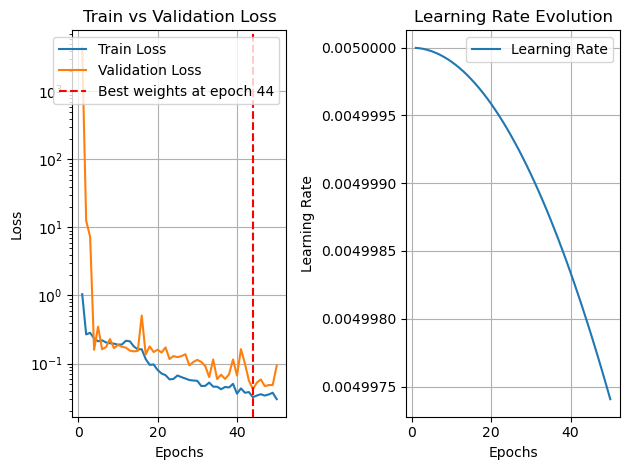

The retained weights are from epoch 44 (val_loss = 0.042073).


In [52]:
data_path = 'data'
epochs = 50
batch_size = 64
model_save_path = 'models/test_.weights.h5'

#best ever hyper mini v3
trained_model, training_history = train_model(
    data_path=data_path,
    epochs=epochs,
    batch_size=batch_size,
    model_save_path=model_save_path
)

Load the train model 

In [19]:
model = value_model() 
model.load_weights(model_save_path)


## Play chess using our evaluation function: alpha-beta search

First, let's load the best trained model.

In [20]:
model = tf.keras.models.load_model('models/Best_value_model.h5', compile=False)

We define the alpha-beta algorithm that enables to give an evaluation of the board by exploring the branches efficiently (heuristic approach).  
We also define play_nn that chooses the move based on the evaluations given by alpha-beta.  
Finaly play_game simulates a game between a random player and our engine that uses both alpha-beta and our trained model. 



In [21]:
def alpha_beta_deep(model, position, depth, alpha=float('-inf'), beta=float('inf')):
    # Convert the board to its FEN representation (used in evaluation)
    fen = position.fen()
    # Base case: if depth is 0, evaluate the board using the model
    if depth == 0:
        return evaluate_board(model, fen)
    else:
        # For black, we maximize the evaluation value (negamax formulation)
        if position.turn == chess.BLACK:
            for move in position.legal_moves:
                position.push(move)  # Make the move on the board
                value = alpha_beta_deep(model, position, depth - 1, -beta, -alpha)
                position.pop()  # Undo the move after evaluation
                alpha = max(alpha, value)  # Update alpha if a better move is found
                if alpha >= beta:  # Beta cutoff: stop exploring this branch
                    break
            return alpha
        # For white, we minimize the evaluation value
        if position.turn == chess.WHITE:
            for move in position.legal_moves:
                position.push(move)  # Make the move on the board
                value = alpha_beta_deep(model, position, depth - 1, -beta, -alpha)
                position.pop()  # Undo the move after evaluation
                beta = min(beta, value)  # Update beta if a better move (lower score) is found
                if alpha >= beta:  # Alpha cutoff: stop exploring this branch
                    break
            return beta

def evaluate_move(model, move, board, depth):
    # Create a copy of the board to safely simulate the move
    candidate_board = board.copy()
    candidate_board.push(move)  # Apply the candidate move
    # Return the move along with its evaluation using alpha_beta_deep
    return move, alpha_beta_deep(model, position=candidate_board, depth=depth)

def play_nn(model, fen, depth):
    # Convert the FEN to a chess board object
    board = chess.Board(fen=fen)
    best_move_score = float("-inf")
    best_move = None

    # Evaluate all legal moves concurrently using ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_move = {
            executor.submit(evaluate_move, model, move, board, depth): move 
            for move in board.legal_moves
        }
        # Process each completed future and update the best move if needed
        for future in concurrent.futures.as_completed(future_to_move):
            move, candidate_move_score = future.result()
            if candidate_move_score > best_move_score:
                best_move = move
                best_move_score = candidate_move_score

    print(f'{best_move}: {best_move_score}')
    # Return the best move as a string in standard algebraic notation
    return str(best_move)

# Define a random player that makes a random legal move
def play_random_move(board):
    legal_moves = list(board.legal_moves)
    move = random.choice(legal_moves)
    board.push(move)
    return move

def play_game(model, ai_function, depth):
    """
    Simulate a chess game between a random mover (simulating the user) and the AI.
    
    Parameters:
      model (object): The evaluation model used by the AI.
      ai_function (function): Function that picks a move based on the model's evaluation.
      depth (int): The search depth for the alpha-beta algorithm.
      
    Returns:
      str: The final game result (e.g., "1-0", "0-1", or "1/2-1/2").
    """
    board = chess.Board()  # Start with the initial chess position
    currentGameMoves = []
    # Continue the game until there is an outcome (checkmate, stalemate, etc.)
    while board.outcome() is None:
        if board.turn == chess.WHITE:
            # White makes a random move (user simulation)
            move = play_random_move(board)
        elif board.turn == chess.BLACK:
            # Black uses the AI to choose the best move
            move = ai_function(model, board.fen(), depth)
            board.push_san(move)  # Apply the move using Standard Algebraic Notation
            print(f'AI move: {move}')
        currentGameMoves.append(move)
        
    # Display the final board state as an SVG image
    display(SVG(board._repr_svg_()))
    # Return the result of the game
    return board.outcome().result()


Based on the basic elo update formula we could simulate games against a stockfish player. After each game, stockfish elo increases and we update our elo scor. 
$$
R_{\text{new}} = R_{\text{old}} + K \times (S - E)
$$

où :  
- $ R_{\text{new}} $ is the new ranking,  
- $ R_{\text{old}} $ is the old ranking,  
- $ K $ is a constant, 32 is a commun value,  
- $ S $ is the obtained score: 1 for victory, 0.5 for nul, 0 for defeat,
- $ E $ is the gain expectancy :

$$
E = \frac{1}{1 + 10^{(R_{\text{opponent}} - R_{\text{old}}) / 400}}
$$

where $ R_{\text{opponent}} $ is the opponent elo.  
However, it is very difficult to make a stockfish engine play at a target elo. The model never really goes beyond 1000 elos which would be necessary to evaluate our model. That is why we will only play games against a basic player to see if the model has really learned.



d7d5: -0.005557987838983536
AI move: d7d5
e7e5: 0.006296645849943161
AI move: e7e5
d5d4: 0.01798199489712715
AI move: d5d4
b8c6: 0.03283197060227394
AI move: b8c6
f8b4: 0.10033784806728363
AI move: f8b4
b4d2: 0.1700289100408554
AI move: b4d2
g8f6: 0.1306031197309494
AI move: g8f6
d4e3: 0.2634314000606537
AI move: d4e3
e3d2: 0.590636670589447
AI move: e3d2
e8g8: 0.6515410542488098
AI move: e8g8
d2e1q: 0.801495373249054
AI move: d2e1q
e1a5: 0.9303956627845764
AI move: e1a5
g7g6: 0.9939308762550354
AI move: g7g6
c6d4: 1.024500846862793
AI move: c6d4
d4c6: 1.0150189399719238
AI move: d4c6
e5d4: 1.0056391954421997
AI move: e5d4
b7b6: 0.9724865555763245
AI move: b7b6
d4d3: 0.969931423664093
AI move: d4d3
g8h8: 0.9965934157371521
AI move: g8h8
d8d7: 0.9489896893501282
AI move: d8d7
f6g8: 0.9578964114189148
AI move: f6g8
f7e6: 0.9927807450294495
AI move: f7e6
c6d8: 0.9845922589302063
AI move: c6d8
a5e1: 0.937041699886322
AI move: a5e1
e1a5: 0.975178062915802
AI move: e1a5
d7e8: 1.0233099460601

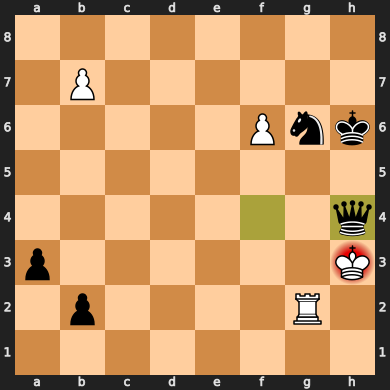

e7e5: -0.010675724595785141
AI move: e7e5
d7d5: 0.022170651704072952
AI move: d7d5
b8c6: 0.05122562125325203
AI move: b8c6
d8h4: inf
AI move: d8h4


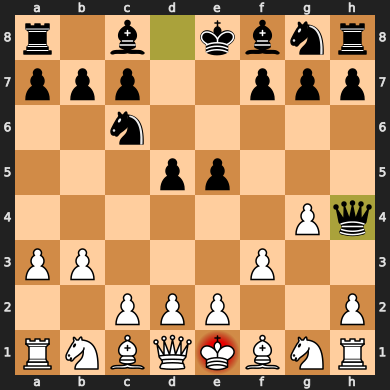

d7d5: -0.029603781178593636
AI move: d7d5
e7e6: -0.01803971640765667
AI move: e7e6
e6e5: 0.00032357126474380493
AI move: e6e5
e5d4: 0.2330862134695053
AI move: e5d4
b8c6: 0.3645896315574646
AI move: b8c6
d5c4: 0.4296238422393799
AI move: d5c4
g8f6: 0.45944878458976746
AI move: g8f6
d8c7: 0.6247434616088867
AI move: d8c7
c4d3: 0.6532462239265442
AI move: c4d3
c7e5: 0.7168787121772766
AI move: c7e5
d4e3: 0.6517555117607117
AI move: d4e3
e3f2: 0.7674713730812073
AI move: e3f2
e5h5: 0.7889733910560608
AI move: e5h5
c8g4: 0.7974324822425842
AI move: c8g4
g4e2: 0.8758171796798706
AI move: g4e2
h5e2: 0.724399745464325
AI move: h5e2
f6g4: 0.6916810870170593
AI move: f6g4
e8c8: 0.7523149847984314
AI move: e8c8
f8b4: 0.7110458612442017
AI move: f8b4
f7f6: 0.7278429865837097
AI move: f7f6
c8d7: 0.6962957382202148
AI move: c8d7
f2g1n: 0.7417755126953125
AI move: f2g1n
g4e5: 0.8070123791694641
AI move: g4e5
g1h3: 0.8209513425827026
AI move: g1h3
b7b5: 0.8159896731376648
AI move: b7b5
c6e7: 0.769529

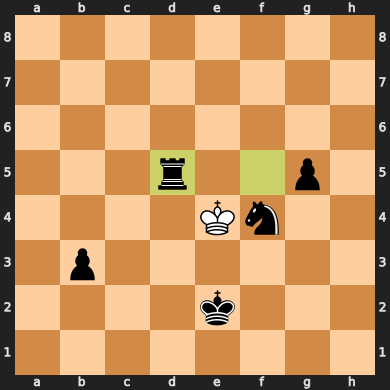

Wins: 2, Losses: 0, Draws: 1
Estimated Elo: 129.99999972319776
opponent Elo: 3500


In [ ]:
# Play several games against a random player
num_games = 3
results = []
for _ in range(num_games):
    result = play_game(model, play_nn, depth=1)
    results.append(result)

# Compute the statistics
wins = results.count('0-1')
losses = results.count('1-0')
draws = results.count('1/2-1/2')

print(f'Wins: {wins}, Losses: {losses}, Draws: {draws}')




On 3 games, our AI won, the only reason we got a draw in the final game is because ouf the maximum move limit.  
That's why we can conclude that it worked. 

# Reinforcement Learning approach: creating the next alpha-zero !


## Model to train

We trained a resnet type model with a policy head to learn from (8, 8, 14) representation of a chess board and produce a (8, 8, 73) tensor, convertible to moves and probabilities.

In [22]:
def policy_model(input_shape=(8, 8, 14)):
    """
    Creates a neural network model for policy prediction with an output shape of (8, 8, 73).

    Args:
        input_shape (tuple): Shape of the input (default is 8x8x14).

    Returns:
        model: A Keras model with an output of shape (8, 8, 73).
    """
    # Input layer
    input_layer = Input(shape=input_shape, name="input_layer")  # Input of shape (8, 8, 14)
    
    # Initial convolutional block
    x = Conv2D(256, (3, 3), padding="same", name="conv_initial")(input_layer)
    x = BatchNormalization(name="bn_initial")(x)
    x = Activation("relu", name="activation_initial")(x)

    # Adding multiple residual blocks
    for i in range(3):  # Add 3 residual blocks
        residual = x
        x = Conv2D(256, (3, 3), padding="same", name=f"conv1_residual_{i}")(x)
        x = BatchNormalization(name=f"bn1_residual_{i}")(x)
        x = Activation("relu", name=f"activation1_residual_{i}")(x)
        x = Conv2D(256, (3, 3), padding="same", name=f"conv2_residual_{i}")(x)
        x = BatchNormalization(name=f"bn2_residual_{i}")(x)
        x = Add(name=f"add_residual_{i}")([x, residual])
        x = Activation("relu", name=f"activation2_residual_{i}")(x)

    # Policy head
    policy_head = Conv2D(73, (1, 1), padding="same", name="policy_conv")(x)  # 73 channels for move types
    policy_head = BatchNormalization(name="policy_bn")(policy_head)
    policy_head = Activation("relu", name="policy_activation")(policy_head)

    # Spatial softmax to produce normalized probabilities over each position (8x8)
    policy_output = Softmax(axis=-1, name="policy_softmax")(policy_head)  # Normalization over 73 move types

    # Complete model
    model = Model(inputs=input_layer, outputs=policy_output, name="policy_model")
    
    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
    )

    return model

# Example usage
untrained_policy = policy_model()
untrained_policy.summary()


Model: "policy_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8, 8, 14)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_initial        │ (None, 8, 8, 256) │     32,512 │ input_layer[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_initial          │ (None, 8, 8, 256) │      1,024 │ conv_initial[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_initial  │ (None, 8, 8, 256) │          0 │ bn_initial[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_residual_0    │ (None, 8, 8, 256) │    590,080 │ activation_initi… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1_residual_0      │ (None, 8, 8, 256) │      1,024 │ conv1_residual_0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation1_residu… │ (None, 8, 8, 256) │          0 │ bn1_residual_0[0… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_residual_0    │ (None, 8, 8, 256) │    590,080 │ activation1_resi… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2_residual_0      │ (None, 8, 8, 256) │      1,024 │ conv2_residual_0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_residual_0      │ (None, 8, 8, 256) │          0 │ bn2_residual_0[0… │
│ (Add)               │                   │            │ activation_initi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation2_residu… │ (None, 8, 8, 256) │          0 │ add_residual_0[0… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_residual_1    │ (None, 8, 8, 256) │    590,080 │ activation2_resi… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1_residual_1      │ (None, 8, 8, 256) │      1,024 │ conv1_residual_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation1_residu… │ (None, 8, 8, 256) │          0 │ bn1_residual_1[0… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_residual_1    │ (None, 8, 8, 256) │    590,080 │ activation1_resi… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2_residual_1      │ (None, 8, 8, 256) │      1,024 │ conv2_residual_1… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_residual_1      │ (None, 8, 8, 256) │          0 │ bn2_residual_1[0

 Total params: 3,599,213 (13.73 MB)

 Trainable params: 3,595,483 (13.72 MB)

 Non-trainable params: 3,730 (14.57 KB)

## One step of Reinforcement for the policy. 

### Load the current Policy model + initialize a stockfish engine for the value function

In [23]:
# Load the latest policy model
policy_func = tf.keras.models.load_model('models/politique/V10.keras' )

/Users/theaudaudiffret/anaconda3/envs/environnement_polyvalent/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 66 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
# Set a stockfish engine to evaluate the board 
stockfish = Stockfish(
        path=path_stockfish,
        parameters={
            "Threads": 4
        }
    )
stockfish.set_depth(3)

# Evaluation function by stockfish
def evaluate_position_stockfish(board):
    stockfish.set_fen_position(board.fen())
    return stockfish.get_evaluation()['value']

### Monte-Carlo tree search implementation

Implementation of the Monte Carlo Tree Search (MCTS) algorithm for playing chess. Algorithm includes key components:

1. **MCTSNode Class**: Represents a node in the search tree, storing the game state, parent node, children nodes, visit count, total value, and policy probabilities.

2. **Node Expansion**: Adds new child nodes based on untried legal moves, using policy probabilities predicted by a neural network.

3. **Node Selection**: Selects the best child node based on a combination of the node's value (Q-value) and an exploration term (U-value), which encourages exploring less-visited nodes.

4. **Simulation**: Performs a rollout from the selected node to estimate the outcome of the game, using a neural network-based evaluation function. Here we use the function hyper_fake_simulation (fake because we use stockfish instead of our own value function)

5. **Backpropagation**: Updates the visit count and total value of the nodes along the path from the root to the selected node based on the simulation result.

6. **Policy Target Calculation**: Computes a policy target based on the visit counts of the child nodes, optionally applying a temperature parameter to control the exploration-exploitation trade-off. This will be used to train our policy

7. **Dirichlet Noise**: Adds noise to the policy probabilities to encourage exploration, particularly in the early stages of the game.

8. **MCTS Function**: Orchestrates the MCTS process, including selection, expansion, simulation, and backpropagation, to find the best move.

9. **Play Function**: Uses the MCTS algorithm to play a move. 


In [25]:
class MCTSNode:
    def __init__(self, state, parent=None):
        self.state = state  # Game state (instance of chess.Board)
        self.parent = parent
        self.children = {}  # Dictionary {move: MCTSNode}
        self.visit_count = 0  # Number of visits of the node
        self.total_value = 0  # Sum of simulation results
        self.policy = None  # Initial probabilities of legal moves

    def is_fully_expanded(self):
        """Checks if all legal moves have been explored."""
        if self == None: 
            print(self)
        return len(self.children) == len(list(self.state.legal_moves))

    def expand(self, policy_func):
        """Adds an unexplored child with probabilities from the CNN."""
        untried_moves = [move for move in self.state.legal_moves if move not in self.children]

        if untried_moves:
            if self.policy is None:
                # Predict the policy and value with the CNN
                board_tensor = board_to_tensor(self.state)
                board_tensor = np.expand_dims(board_tensor, axis=0)

                policy_tensor = policy_func.predict(board_tensor)
                self.policy = policy_tensor
            
            # Add the best move as a child
            probabilities = tensor_to_move_probabilities(self.policy, self.state)
            untried_probabilities = {move.uci(): probabilities[move.uci()] for move in untried_moves}

            # Choose a move based on the probabilities
            best_move = sorted(untried_probabilities.items(), key=lambda item: item[1], reverse=True)[0][0]
            best_move = chess.Move.from_uci(best_move)
            next_state = self.state.copy()
            next_state.push(best_move)
            child_node = MCTSNode(next_state, parent=self)
            self.children[best_move] = child_node
            return child_node
        return None

    def best_child(self):
        """Selects the best child node."""
        best_score = float('-inf')
        best_move = None
        best_child = None
        if self.state.is_game_over():
            return None, None
        if not self.children:
            return None, None

        for move, child in self.children.items():
            # Compute Q(s, a)
            q_value = child.total_value / (child.visit_count + 1e-6)

            # Compute N(s, a) and N(s)
            n_sa = child.visit_count

            # Compute C(s)
            c_s = 1.25

            if child.policy is not None:
                probabilities = tensor_to_move_probabilities(child.policy, child.state)
                proba = sorted(probabilities.items(), key=lambda item: item[1], reverse=True)[0][1]
            else:
                proba = 0

            # Compute U(s, a)
            u_sa = c_s * proba * (
                np.sqrt(sum(c.visit_count for c in self.children.values())) / (1 + n_sa)
            )

            # Total score
            score = q_value + u_sa

            if score > best_score:
                best_score = score
                best_move = move
                best_child = child

        return best_move, best_child

    def calculate_policy_target(self, tau=1.0):
        """
        Calculates a target policy based on move visit counts, applying temperature tau.
        """
        policy_target = {}
        for move, child in self.children.items():
            policy_target[move.uci()] = (child.visit_count ** (1 / tau)) if tau > 0 else 0

        # Normalize
        total = sum(policy_target.values())
        for move in policy_target:
            policy_target[move] = policy_target[move] / total if total > 0 else 0

        return policy_target

    def add_dirichlet_noise(self, alpha=0.15, epsilon=0.2):
        """
        Adds Dirichlet noise to the initial policy to encourage exploration.
        """
        if self.policy is not None:
            noise = np.random.dirichlet([alpha] * len(self.policy.flatten()))
            self.policy = (1 - epsilon) * self.policy + epsilon * noise.reshape(self.policy.shape)


def backpropagate(node, result):
    """Updates the statistics of the node and its ancestors."""
    while node:
        node.visit_count += 1
        node.total_value += result
        node = node.parent


def hyper_fake_simulation(evaluation_func, state, reverse):
    """Performs a random simulation from a given state."""
    multiple = 1
    if reverse == True:
        multiple = -1
    score = multiple * evaluation_func(state)
    return score


def mcts(evaluation_func, policy_func, state, num_simulations, reverse=False, tau=1.0, use_dirichlet_noise=False, move_count=0):
    """Monte Carlo Tree Search to find the best move."""
    root = MCTSNode(state)

    # Apply Dirichlet noise only for the first 10 moves
    if use_dirichlet_noise and move_count < 10:
        root.add_dirichlet_noise()

    for _ in range(num_simulations):
        # Step 1: Selection
        node = root
        if node is None:
            break

        while node is not None and node.is_fully_expanded() and node.children:
            _, node = node.best_child()

        # Step 2: Expansion
        if node is not None and not node.is_fully_expanded():
            node = node.expand(policy_func)
        if node is None:
            break
        # Step 3: Simulation
        result = hyper_fake_simulation(evaluation_func, node.state.copy(), reverse)

        # Step 4: Backpropagation
        backpropagate(node, result)

    # Generate target policy at the root
    policy_target = root.calculate_policy_target(tau=tau)

    # Best move from the root
    best_move, _ = root.best_child()

    return best_move, policy_target


def play_mcts(evaluation_func, policy_func, state, num_simulations=100, reverse=False, tau=1.0, use_dirichlet_noise=False, move_count=0):
    """Plays a move using MCTS with the target policy."""
    # Check if a checkmate is possible
    for move in state.legal_moves:
        next_state = state.copy()
        next_state.push(move)
        if next_state.is_checkmate():
            print(f"Mate found: {move}")
            return move, {}  # No target policy is needed if mate is found

    # Otherwise, proceed with MCTS
    best_move, policy_target = mcts(evaluation_func, policy_func, state, num_simulations, reverse, tau, use_dirichlet_noise, move_count)
    return best_move, policy_target

max_moves = 200


### Create a self play mode to simulate games 

We want to record the board at each move, the moves played and the target policy. This history will be used to train the policy. 

In [26]:
def play_game_mcts_self_play(evaluation_func, policy_func, num_simulations=100, history=[], tau=1.0, use_dirichlet_noise=False):
    """
    Plays a game using MCTS, with a temperature Tau and Dirichlet noise.

    Args:
        evaluation_func (function): Function to evaluate the board.
        policy_func (function): Function to predict policy.
        num_simulations (int): Number of simulations for each move.
        history (list): History of moves played.
        tau (float): Temperature to adjust the target policy.
        use_dirichlet_noise (bool): Indicates if Dirichlet noise is enabled.

    Returns:
        list: History of moves played with target policies.
    """
    board = chess.Board()
    move_count = 0
    reverse = False
    while not board.is_game_over() and move_count < max_moves:
        if move_count < 10:
            tau = 1.0
        elif move_count < 20:
            tau = 0.5
        else:
            tau = 0.1

        best_move, policy_target = play_mcts(evaluation_func, policy_func, board, num_simulations=num_simulations, reverse=reverse, tau=tau, use_dirichlet_noise=use_dirichlet_noise, move_count=move_count)

        board.push(best_move)
        history.append({
            'position': board.fen(),
            'best_move': best_move,
            'policy_target': policy_target
        })

        move_count += 1

        if board.is_game_over():
            break
        if move_count >= 900:
            display(SVG(board._repr_svg_()))

        reverse = not reverse

    # Record the final result
    if move_count >= max_moves:
        result = 0

    outcome = board.outcome()
    if outcome is not None:
        result = 1 if outcome.winner == chess.WHITE else -1 if outcome.winner == chess.BLACK else 0

    for entry in history:
        entry['result'] = result
    display(SVG(board._repr_svg_()))

    print(f"Game Over: {result}")
    return history


### Simulate games in self-play mode

In [27]:
def simul_n_parties(n, num_simulations):
    """
    Simulate multiple chess games using Monte Carlo Tree Search (MCTS) self-play.

    Parameters:
    n (int): The number of games to simulate.
    num_simulations (int): The number of MCTS simulations to perform per move.

    Returns:
    list: A list containing the history of the simulated games.
    """
    history = []
    for _ in tqdm(range(n), desc="Simulating games"):
        history = play_game_mcts_self_play(evaluation_func= evaluate_position_stockfish, policy_func=policy_func, num_simulations=num_simulations, tau=1.0, use_dirichlet_noise=True)
    return history


Example of simulating 1 game with 20 MCTS steps per move (in alpha-zero paper it is 800)

Simulating games:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

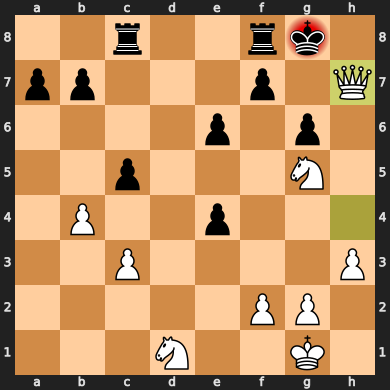

Simulating games: 100%|██████████| 1/1 [00:10<00:00, 10.76s/it]

Game Over: 1
Liste enregistrée dans 'my_list.txt'.


In [28]:
historique = simul_n_parties(n = 1, num_simulations = 20)

# save the result in a txt file 
with open("historique.txt", "w") as file:
    for item in historique:
        file.write(f"{item}\n")

print("Liste enregistrée dans 'my_list.txt'.")

### Train the policy 

In [39]:
# Define the loss function
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Model optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Number of epochs and batch size
num_epochs = 5
batch_size = 32

# Prepare the data: convert `historique` into input and target tensors
def prepare_dataset(historique):
    input_tensors = []
    target_tensors = []
    
    for element in historique:
        position = chess.Board(fen=element['position'])
        input_tensors.append(board_to_tensor(position)) # Tensor (8, 8, 14)
        target_tensors.append(move_probabilities_to_tensor(element['policy_target'], position))  # Tensor (8, 8, 73)

    # Convert to TensorFlow tensors
    inputs = tf.convert_to_tensor(input_tensors, dtype=tf.float32)
    targets = tf.convert_to_tensor(target_tensors, dtype=tf.float32)
    
    return inputs, targets

# Load the data into a Dataset
inputs, targets = prepare_dataset(historique)
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
dataset = dataset.shuffle(buffer_size=len(historique)).batch(batch_size)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for batch_inputs, batch_targets in dataset:

        with tf.GradientTape() as tape:
            # Model predictions
            predictions = policy_func(batch_inputs, training=True) # (batch size, 8,8,73)
            
            # Calculate the loss
            loss = loss_fn(
                tf.reshape(batch_targets, (-1, 73)),
                tf.reshape(predictions, (-1, 73))
            )

        # Calculate and apply gradients
        gradients = tape.gradient(loss, policy_func.trainable_variables)
        optimizer.apply_gradients(zip(gradients, policy_func.trainable_variables))
    
        print(f"Batch Loss: {loss.numpy()}")
    print(f"Epoch {epoch + 1} completed.\n")


Epoch 1/5
(32, 8, 8, 73)
Batch Loss: 0.018810413777828217
(23, 8, 8, 73)
Batch Loss: 0.01966853067278862
Epoch 1 completed.

Epoch 2/5
(32, 8, 8, 73)
Batch Loss: 0.01852532848715782
(23, 8, 8, 73)
Batch Loss: 0.022810446098446846
Epoch 2 completed.

Epoch 3/5
(32, 8, 8, 73)
Batch Loss: 0.01959177851676941
(23, 8, 8, 73)
Batch Loss: 0.018525779247283936
Epoch 3 completed.

Epoch 4/5
(32, 8, 8, 73)
Batch Loss: 0.018980488181114197
(23, 8, 8, 73)
Batch Loss: 0.019113022834062576
Epoch 4 completed.

Epoch 5/5
(32, 8, 8, 73)
Batch Loss: 0.019132044166326523
(23, 8, 8, 73)
Batch Loss: 0.018486393615603447
Epoch 5 completed.



### Save the new version of the model 

In [30]:
policy_func.save("models/politique/test.keras")


## Comparison between MCTS and no MCTS 

The white player plays using the MCTS, the black player only plays the stockfish best move

In [31]:
# Set a stockfish engine to evaluate the board 
stockfish = Stockfish(
        path=path_stockfish,
        parameters={
            "Threads": 4
        }
    )
stockfish.set_depth(2)
stockfish.set_elo_rating(1000)

# Select the best move according to stockfish
def play_stockfish_move(board, stockfish):
    # Set the current position in Stockfish
    stockfish.set_fen_position(board.fen())
    # Get the best move from Stockfish
    best_move = stockfish.get_best_move()
    # Play the best move on the board
    move = chess.Move.from_uci(best_move)
    return move

In [32]:
model_V10 = tf.keras.models.load_model('models/politique/V10.keras')

def play_mcts_vs_no_mcts(nb_of_game, num_simulations=100, history=[], tau=0.2, use_dirichlet_noise=False):
    """
    Plays a game with MCTS, using a temperature Tau and Dirichlet noise.

    Args:
        num_simulations (int): Number of simulations for each move.
        history (list): History of moves played.
        tau (float): Temperature to adjust the target policy.
        use_dirichlet_noise (bool): Indicates if Dirichlet noise is enabled.

    Returns:
        list: History of moves played with target policies.
    """
    board = chess.Board()
    move_count = 0
    while not board.is_game_over() and move_count <= max_moves:
        # MCTS turn (player 1)
        if board.turn == chess.WHITE:
            best_move, _ = play_mcts(evaluation_func=evaluate_position_stockfish, policy_func=model_V10, state=board, num_simulations=num_simulations, reverse=False, tau=tau, use_dirichlet_noise=use_dirichlet_noise, move_count=move_count)
            board.push(best_move)
            move_count += 1

        if board.is_game_over():
            break
        if nb_of_game == 0:
            display(SVG(board._repr_svg_()))

        if board.turn == chess.BLACK:
            best_move = play_stockfish_move(board, stockfish)
            board.push(best_move)
            move_count += 1

        if board.is_game_over():
            break
        
    # Record the final result
    if move_count >= max_moves:
        result = 0
    else: 
        outcome = board.outcome()
        result = 1 if outcome.winner == chess.WHITE else -1 if outcome.winner == chess.BLACK else 0

    for entry in history:
        entry['result'] = result
    if nb_of_game == 0:
        display(SVG(board._repr_svg_()))

    print(f"Game Over: {result}")
    return result, move_count


Example of a game, where white wins, showing that the MCTS works and improves the performances compared to a simple evaluation function. For conveniance, we only display the first game 

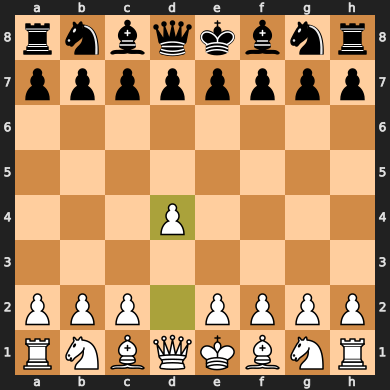

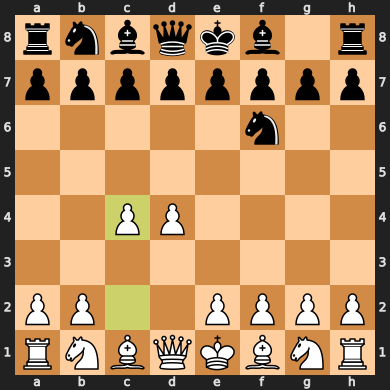

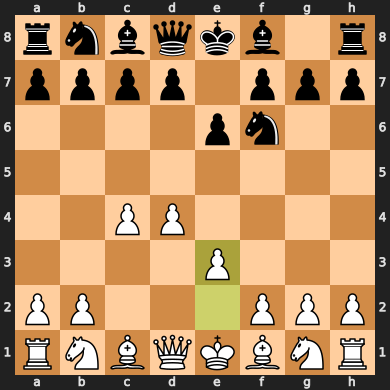

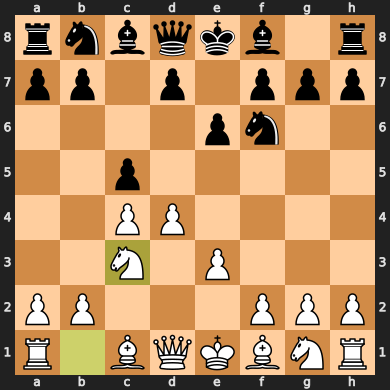

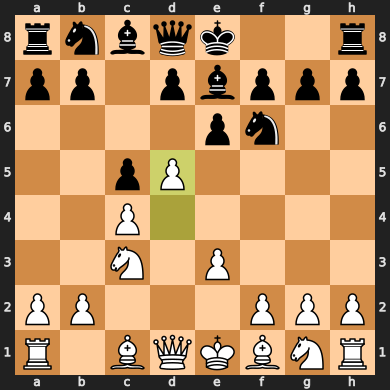

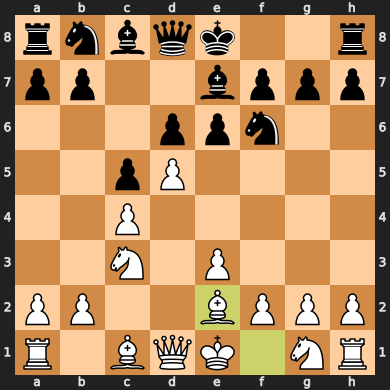

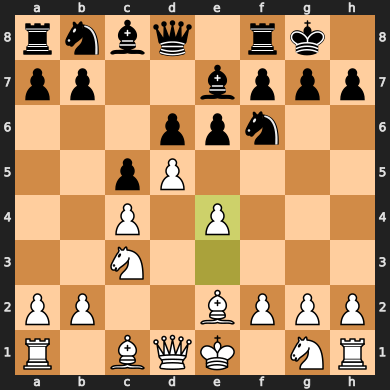

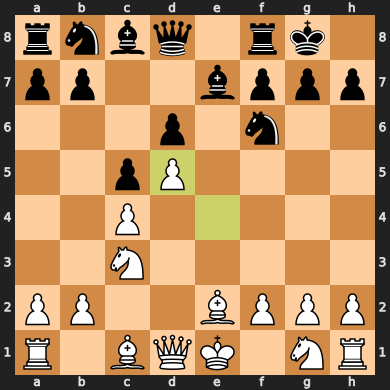

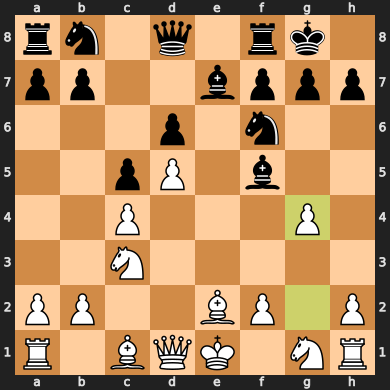

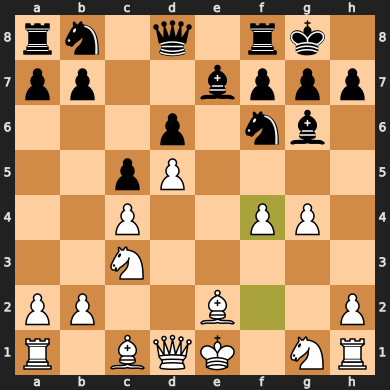

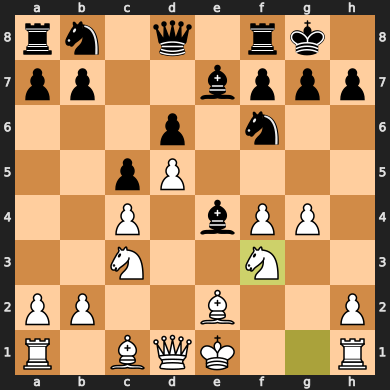

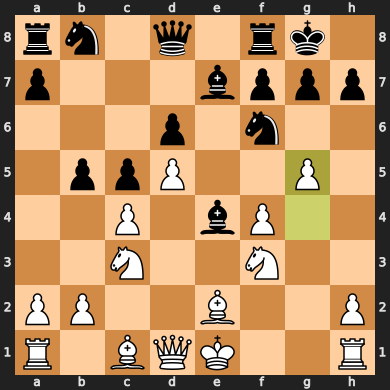

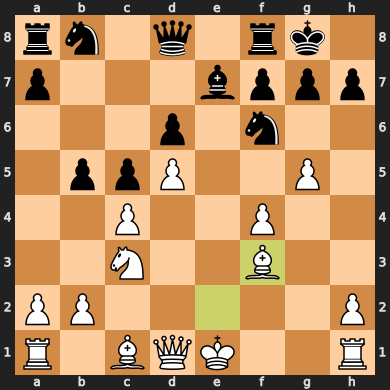

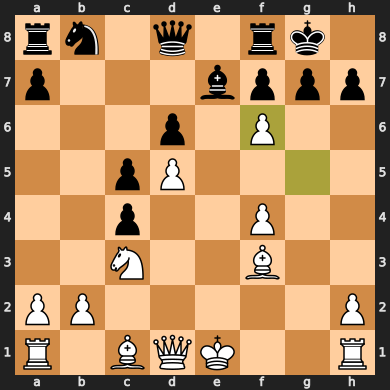

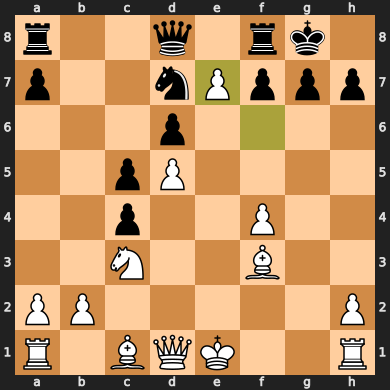

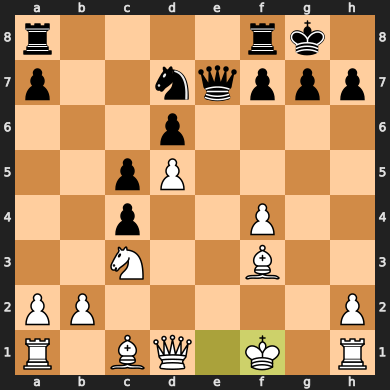

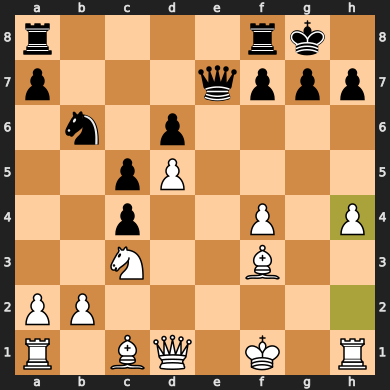

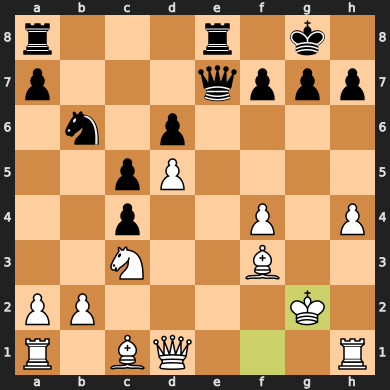

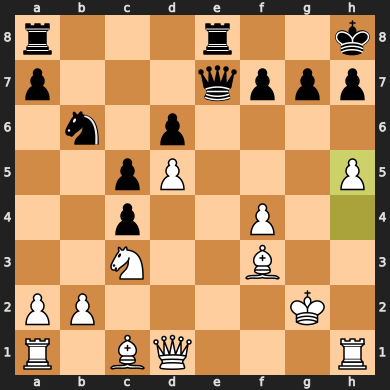

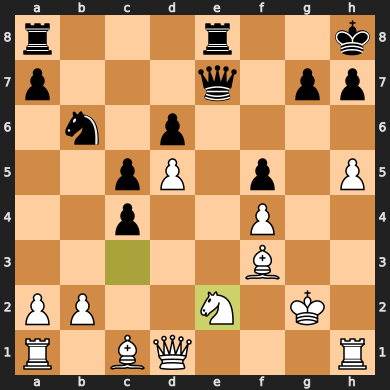

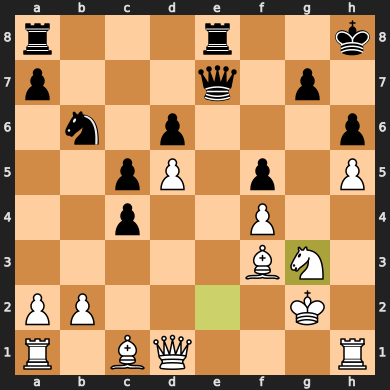

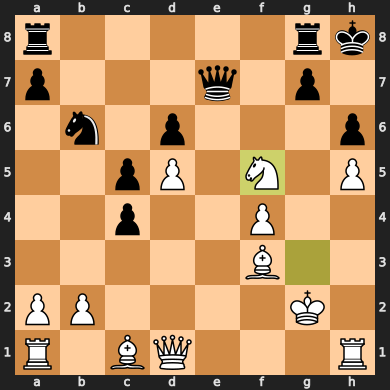

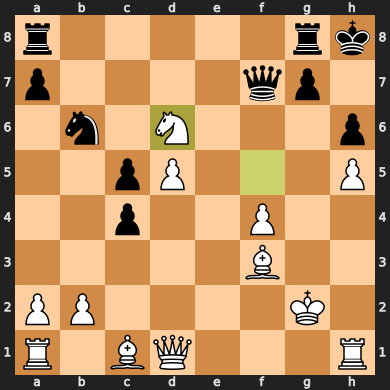

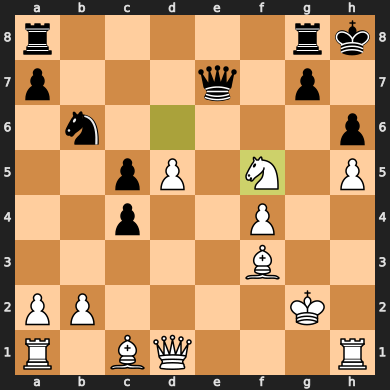

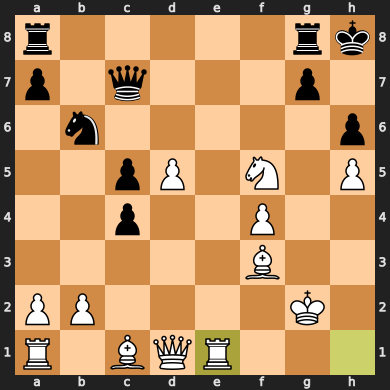

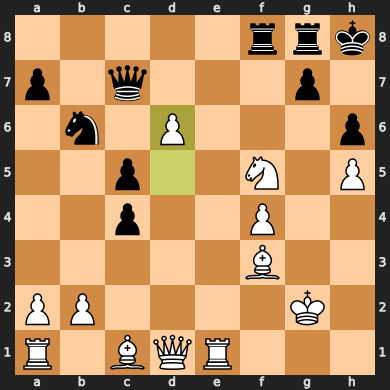

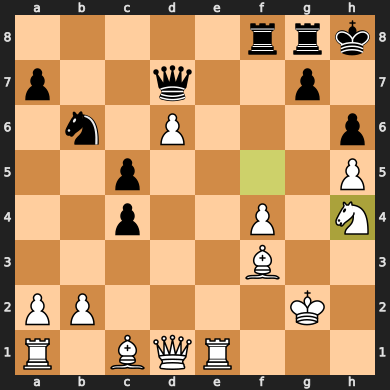

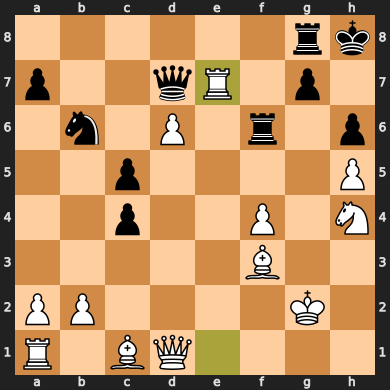

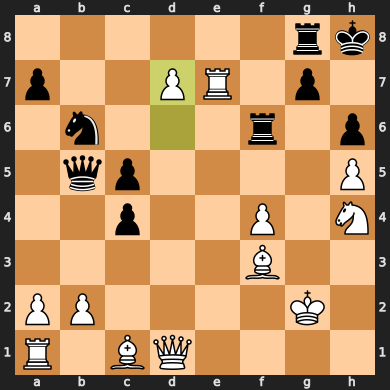

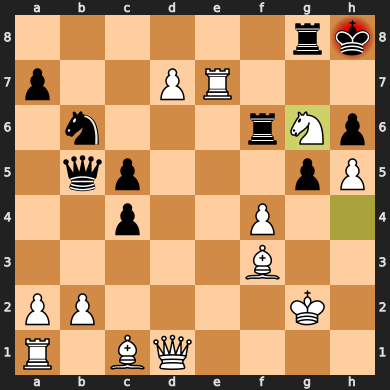

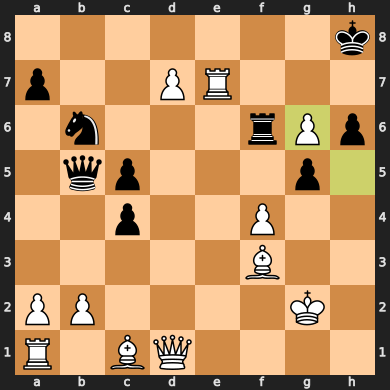

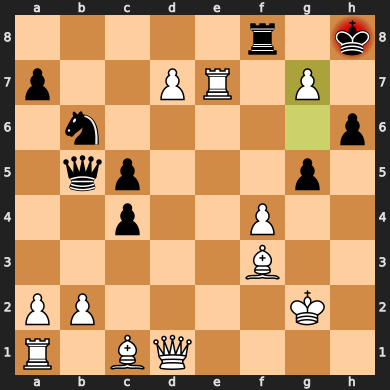

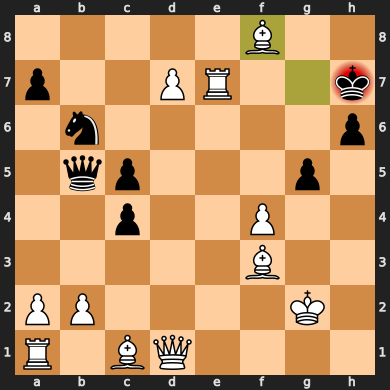

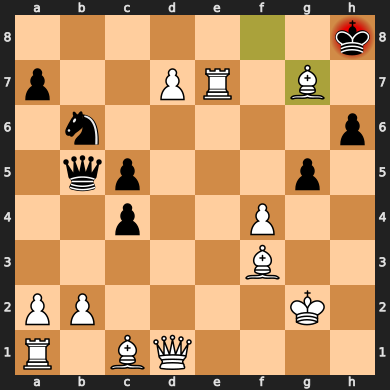

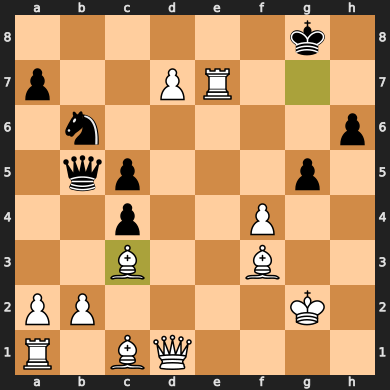

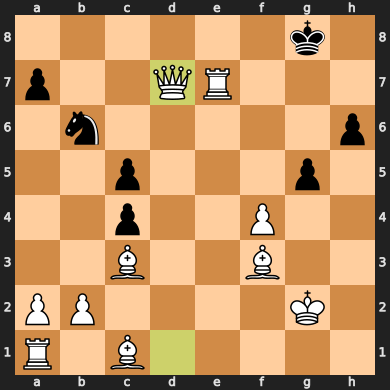

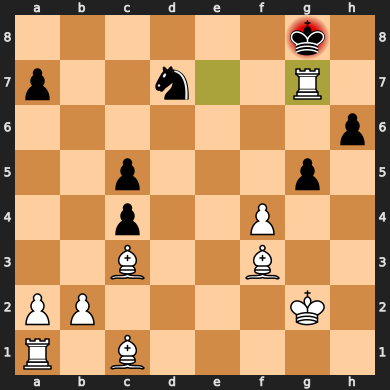

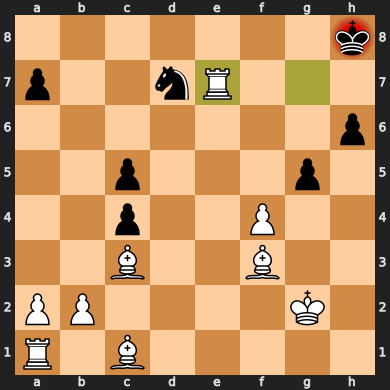

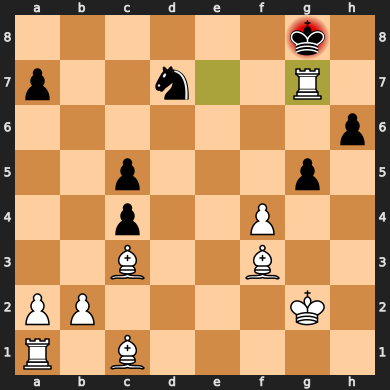

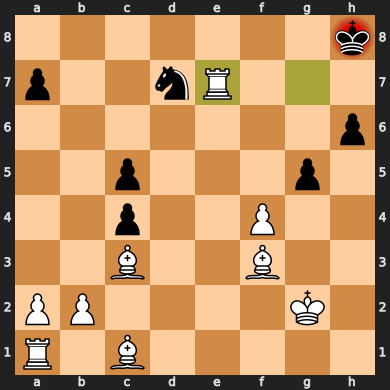

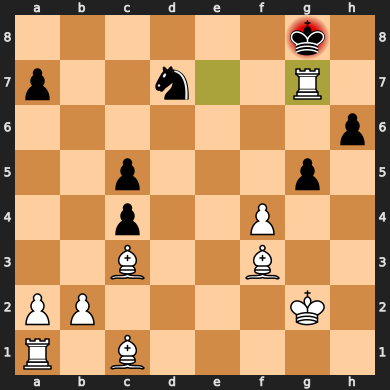

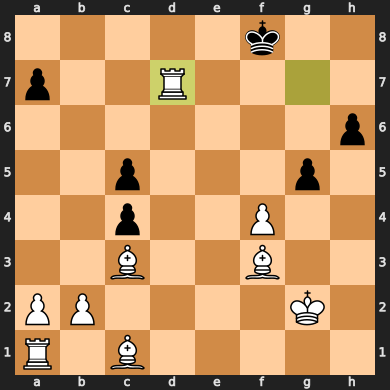

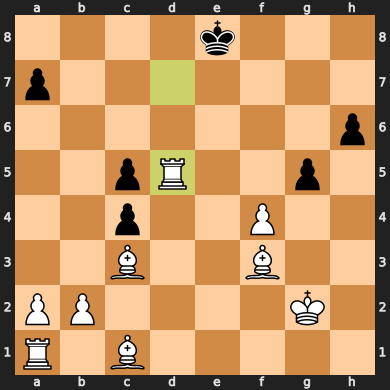

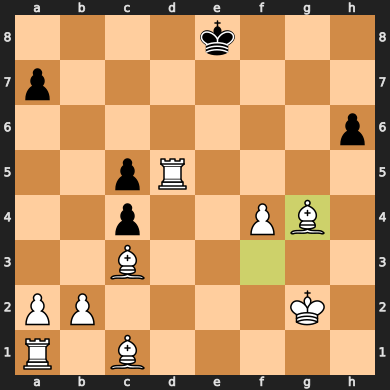

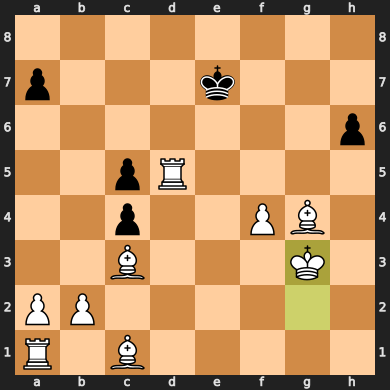

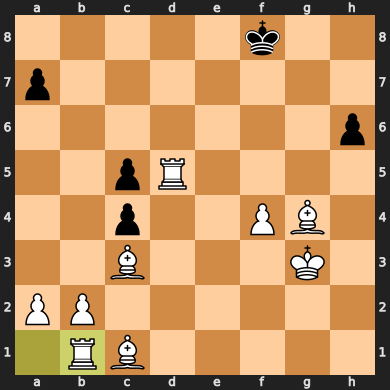

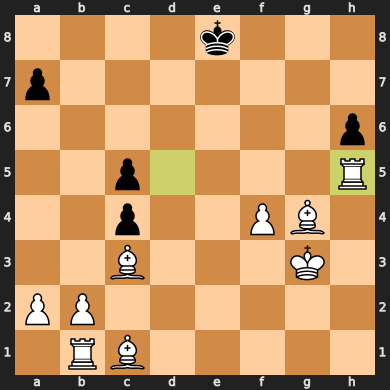

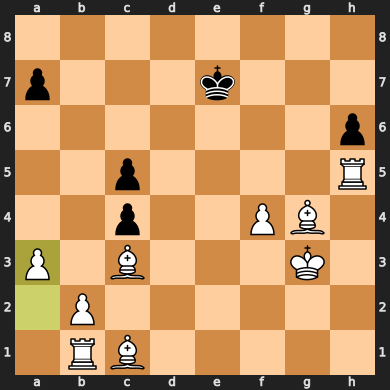

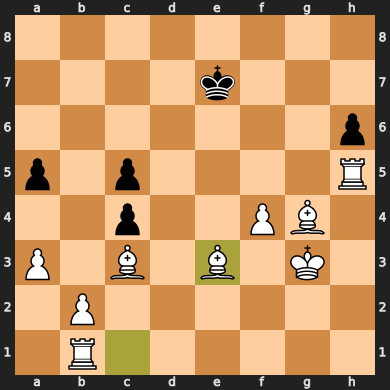

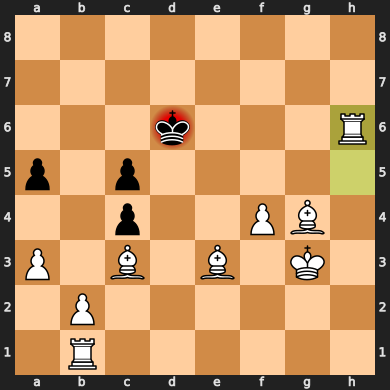

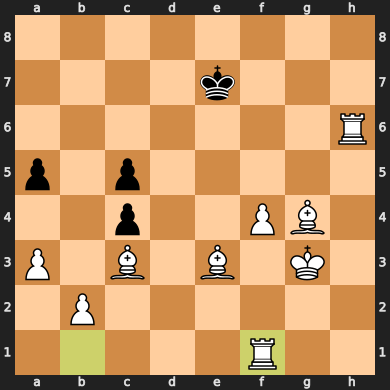

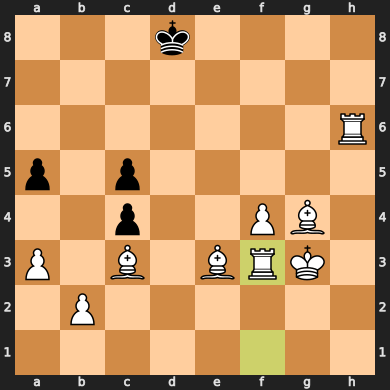

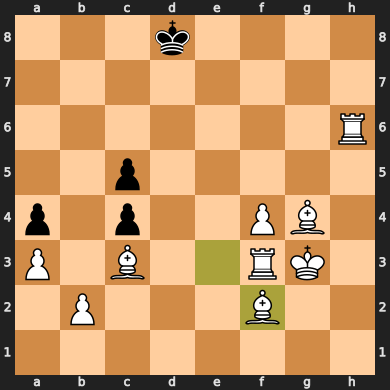

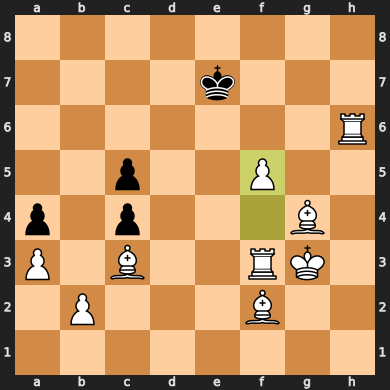

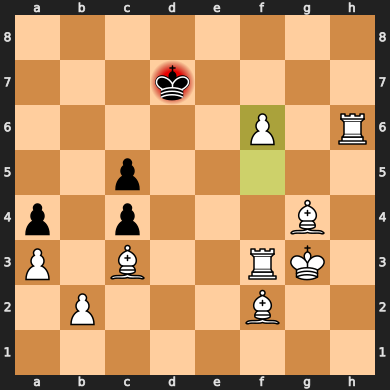

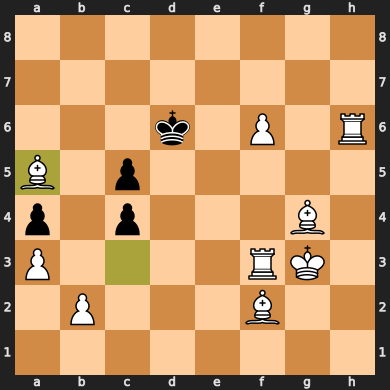

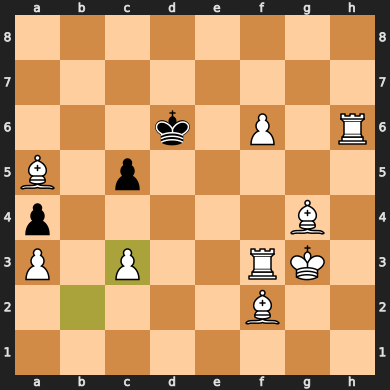

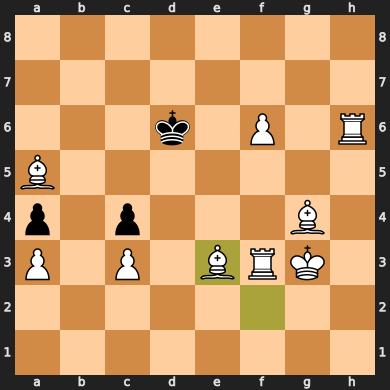

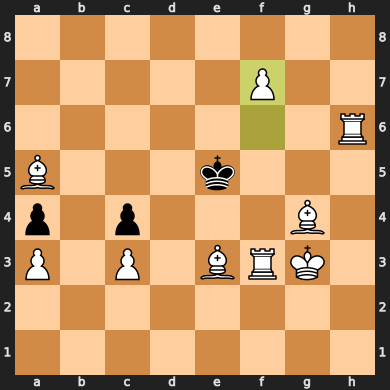

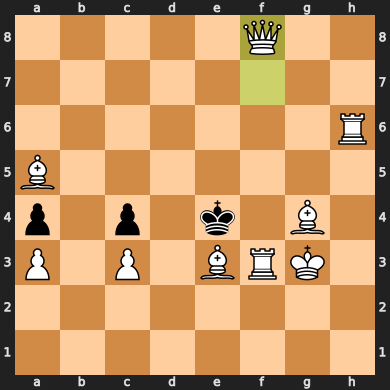

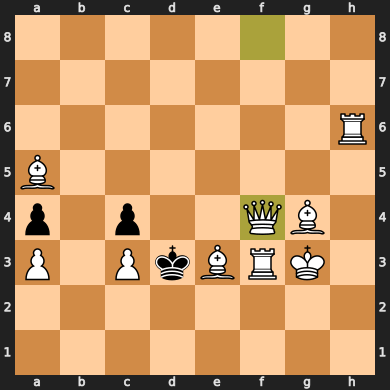

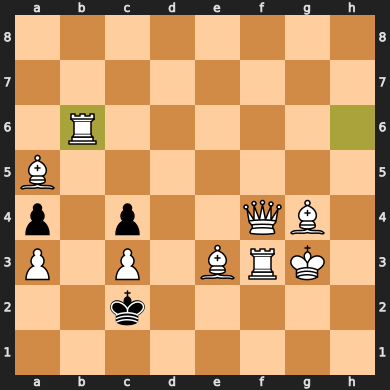

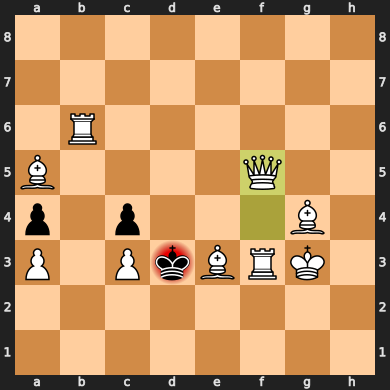

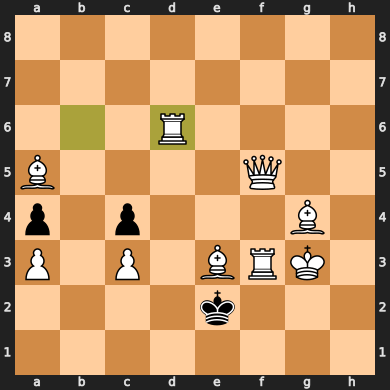

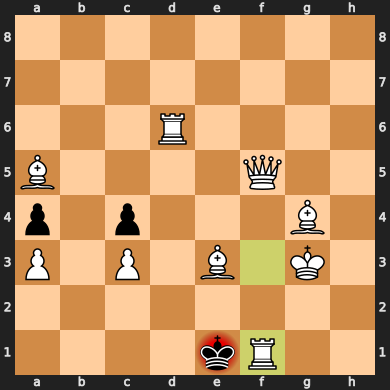

On 20 games, the MCTS won 20


In [18]:
results = []  # List to store the results of each game
number_of_games = 20  # Number of games to simulate

# Suppress the output of the games
with open(os.devnull, 'w') as fnull:
    with redirect_stdout(fnull):
        for i in range(number_of_games):
            # Simulate a game and get the result
            result, _ = play_mcts_vs_no_mcts(nb_of_game=i, num_simulations=40, tau=0.1, use_dirichlet_noise=False)
            results.append(result)  # Append the result to the list

# Print the number of games won by MCTS
print(f'On {number_of_games} games, the MCTS won {sum(results)}')


# Next steps: scaling


A next step could be to implement the code in C or C++ to gain efficiency and be able to explore a depth of 2 or more in a reasonable amount of time. 
We can also think about training the RL phase on GPUs to be able to obtain more appealing results on the RL approach. 

Now that we have efficiently trained a value function and a policy function, we will plug in the value function into the RL approach. This would mean replacing the simulation step given by the stockfish evaluation by our own evaluation. Due to too few training time, we won't be able to demonstrate results on this part, but we are confident that this could be a next step to build a powerfull chess ai. 